# SaaS PLG Growth Analytics - Analysis Demo

This notebook demonstrates the key outputs of the Growth Analytics Pipeline:
- **Gold layer** cohort analysis: Does feature adoption drive conversion?
- **Visualizations**: Conversion rates by feature and usage cohort
- **Key insight**: The real-time collaboration impact on conversion
- **SCD Type 2 time-travel**: Query feature states at any point in time

## 1. Setup

In [7]:
import os

from delta import configure_spark_with_delta_pip
from pyspark.sql import SparkSession

# Resolve project root (one level up from notebooks/)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

builder = (
    SparkSession.builder.appName("SaaS PLG Analysis")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .config("spark.sql.warehouse.dir", os.path.join(PROJECT_ROOT, "spark-warehouse"))
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()
spark.sparkContext.setLogLevel("WARN")

print(f"Project root: {PROJECT_ROOT}")
print(f"Spark version: {spark.version}")
print("SparkSession ready.")

Project root: /home/dell/coding/growth-analytics-pipeline
Spark version: 3.5.8
SparkSession ready.


## 2. Load Gold Metrics

In [8]:
gold_path = os.path.join(PROJECT_ROOT, "data/gold/gold_feature_conversion_impact")
impact_df = spark.read.format("delta").load(gold_path)

print(f"Gold table: {impact_df.count()} rows")
impact_df.show(truncate=False)

Gold table: 16 rows
+----------------+------------------+-----------+---------------+-------------------+-------------------+------------------+
|feature_name    |cohort            |total_users|converted_users|conversion_rate    |avg_days_to_convert|avg_mrr           |
+----------------+------------------+-----------+---------------+-------------------+-------------------+------------------+
|advanced_export |used_feature      |1088       |349            |0.32077205882352944|15.756446991404012 |1584.2578796561604|
|advanced_export |not_available     |1530       |431            |0.28169934640522876|17.0               |1321.7192575406032|
|advanced_export |available_not_used|2382       |660            |0.2770780856423174 |17.740909090909092 |1562.8348484848484|
|ai_insights     |used_feature      |1590       |563            |0.3540880503144654 |13.124333925399645 |1505.5097690941386|
|ai_insights     |not_available     |3410       |877            |0.25718475073313785|19.55074116305587  |

## 3. Visualization - Conversion Rates by Feature

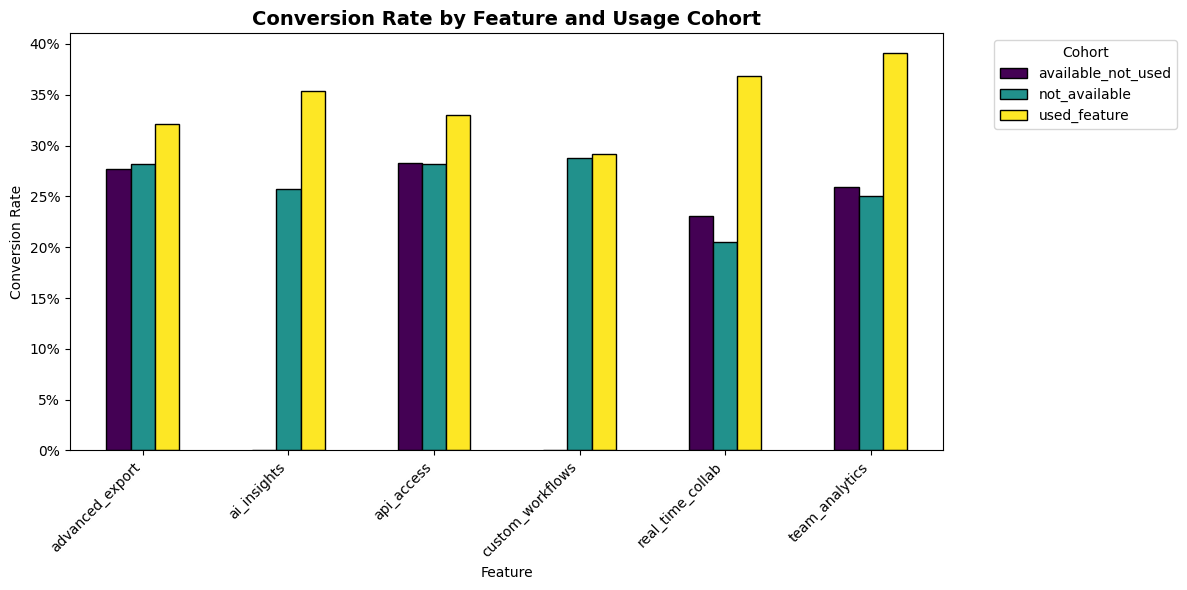

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = impact_df.toPandas()

# Bar chart: Conversion rate by feature and cohort
pivot = pdf.pivot(index="feature_name", columns="cohort", values="conversion_rate")
ax = pivot.plot(kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black")
ax.set_title("Conversion Rate by Feature and Usage Cohort", fontsize=14, fontweight="bold")
ax.set_ylabel("Conversion Rate")
ax.set_xlabel("Feature")
ax.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.tight_layout()
plt.show()

## Real-Time Collaboration Impact

KEY INSIGHT:
Users who tried real-time collaboration: 36.8% conversion rate
Users who didn't try it:                 23.1% conversion rate
Impact: 59.8% conversion lift!


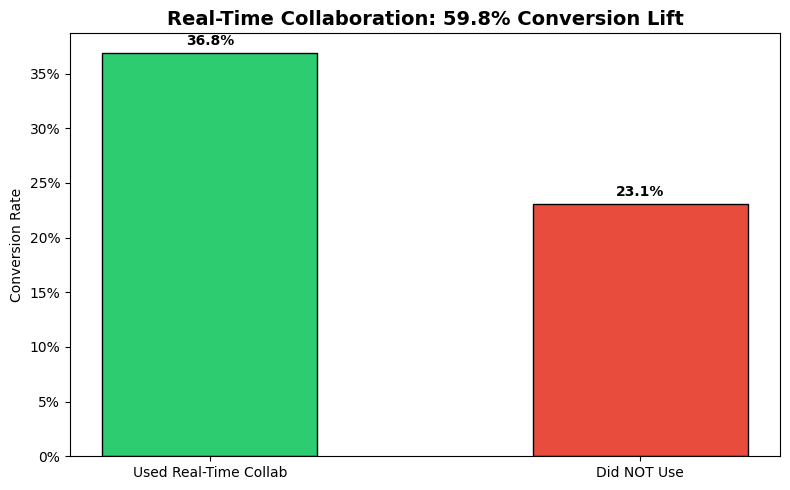

In [10]:
rtc_data = pdf[pdf["feature_name"] == "real_time_collab"]

used_row = rtc_data[rtc_data["cohort"] == "used_feature"]
baseline_row = rtc_data[rtc_data["cohort"] == "available_not_used"]

if not used_row.empty and not baseline_row.empty:
    used_rate = used_row["conversion_rate"].values[0]
    baseline_rate = baseline_row["conversion_rate"].values[0]

    if baseline_rate > 0:
        lift = (used_rate - baseline_rate) / baseline_rate * 100
    else:
        lift = float("inf")

    print(f"KEY INSIGHT:")
    print(f"Users who tried real-time collaboration: {used_rate:.1%} conversion rate")
    print(f"Users who didn't try it:                 {baseline_rate:.1%} conversion rate")
    print(f"Impact: {lift:.1f}% conversion lift!")

    # Side-by-side comparison bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(
        ["Used Real-Time Collab", "Did NOT Use"],
        [used_rate, baseline_rate],
        color=["#2ecc71", "#e74c3c"],
        edgecolor="black",
        width=0.5,
    )
    ax.set_title(
        f"Real-Time Collaboration: {lift:.1f}% Conversion Lift",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylabel("Conversion Rate")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.005,
            f"{height:.1%}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()
else:
    print("Could not find real_time_collab data for the expected cohorts.")
    print("Available features:", pdf["feature_name"].unique())
    print("Available cohorts:", pdf["cohort"].unique())

## 5. Time-Travel Demo (SCD Type 2 Showcase)

The silver `feature_states` table implements **SCD Type 2** (Slowly Changing Dimensions).
Each feature version is tracked with `effective_from` / `effective_to` date ranges,
allowing us to query the state of features at any historical point in time.

In [11]:
silver_feature_states_path = os.path.join(
    PROJECT_ROOT, "data/silver/silver_feature_states"
)
feature_states_df = spark.read.format("delta").load(silver_feature_states_path)
feature_states_df.createOrReplaceTempView("silver_feature_states")

# Show how feature states looked on 2024-04-01
print("=" * 60)
print("Feature states as of 2024-04-01 (historical snapshot)")
print("=" * 60)
early_features = spark.sql("""
    SELECT feature_name, version, effective_from, effective_to
    FROM silver_feature_states
    WHERE effective_from <= '2024-04-01'
      AND effective_to > '2024-04-01'
      AND is_enabled = TRUE
""")
early_features.show(truncate=False)

# Show current state
print("=" * 60)
print("Current feature states (is_current = TRUE)")
print("=" * 60)
current_features = spark.sql("""
    SELECT feature_name, version, effective_from
    FROM silver_feature_states
    WHERE is_current = TRUE
""")
current_features.show(truncate=False)

# Full history view
print("=" * 60)
print("Full SCD Type 2 history")
print("=" * 60)
spark.sql("""
    SELECT feature_name, version, is_enabled, effective_from, effective_to, is_current
    FROM silver_feature_states
    ORDER BY feature_name, effective_from
""").show(truncate=False)

Feature states as of 2024-04-01 (historical snapshot)


+----------------+-------+--------------+------------+
|feature_name    |version|effective_from|effective_to|
+----------------+-------+--------------+------------+
|real_time_collab|v1.0   |2024-01-15    |2024-07-01  |
|ai_insights     |v1.0   |2024-03-01    |2024-10-01  |
+----------------+-------+--------------+------------+

Current feature states (is_current = TRUE)
+----------------+-------+--------------+
|feature_name    |version|effective_from|
+----------------+-------+--------------+
|real_time_collab|v2.0   |2024-07-01    |
|ai_insights     |v2.0   |2024-10-01    |
|advanced_export |v1.0   |2024-05-01    |
|api_access      |v1.0   |2024-07-01    |
|team_analytics  |v1.0   |2024-09-01    |
|custom_workflows|v1.0   |2024-11-01    |
+----------------+-------+--------------+

Full SCD Type 2 history
+----------------+-------+----------+--------------+------------+----------+
|feature_name    |version|is_enabled|effective_from|effective_to|is_current|
+----------------+-------+-

In [12]:
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.
